# Predicting the price of the houses in Boston

### Data attributes


__Input variables__ (predictor variables):

- *CRIM: per capita crime rate by town*
- *ZN: proportion of residential land zoned for lots over 25,000 sq.ft.*
- *INDUS: proportion of non-retail business acres per town*
- *CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)*
- *NOX: nitric oxides concentration (parts per 10 million) [parts/10M]*
- *RM: average number of rooms per dwelling*
- *AGE: proportion of owner-occupied units built prior to 1940*
- *DIS: weighted distances to five Boston employment centres*
- *RAD: index of accessibility to radial highways*
- *TAX: full-value property-tax rate per 10,000[ /10k]*
- *PTRATIO: pupil-teacher ratio by town*
- *B: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town*
- *LSTAT: % lower status of the population*


__Target variable__ (based on sensory data):
- *MEDV: Median value of owner-occupied homes in 1000′𝑠[𝑘 ]* (score between 0 and 10)

### Importing needed packages

In [165]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from transformers import pipeline

import warnings
warnings.filterwarnings('ignore')
shap.initjs()
np.random.seed(0)

In [166]:
path_to_data = "boston.csv"
df = pd.read_csv(path_to_data)
df.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

## heatmap to show correlations

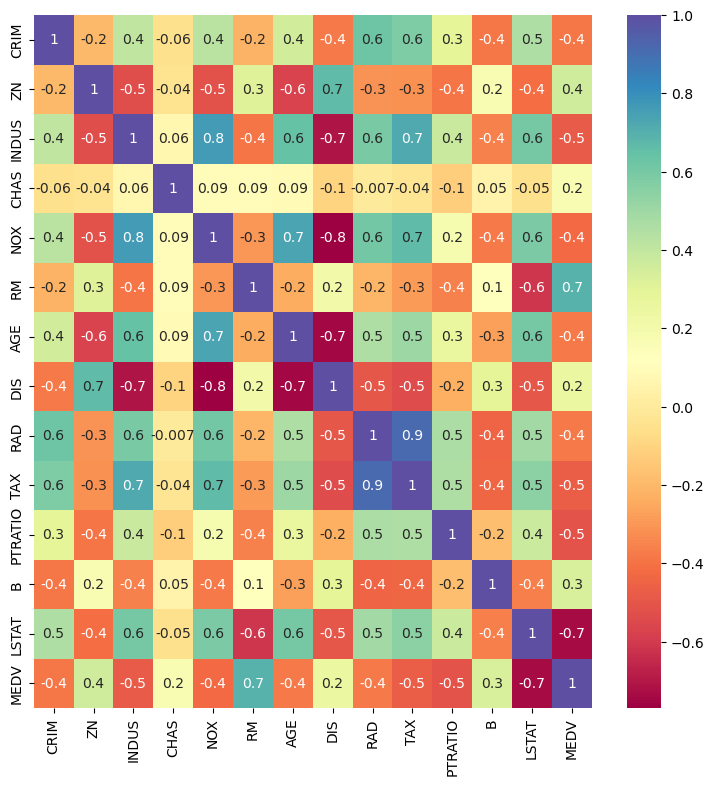

In [167]:
plt.figure(figsize=(9,9))
sns.heatmap(df.corr(), annot=True, fmt="0.1g", cmap='Spectral')
plt.show()

## the highest correlation is between RAD ans TAX (now I can compare models trained with and without one of these variables)

### Dividing data on X / y

In [168]:
X = df.loc[:, ~df.columns.isin(['MEDV'])]
Y = df['MEDV']
X.shape, Y.shape

((506, 13), (506,))

### Splitting data on train / test

In [169]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((404, 13), (404,), (102, 13), (102,))

### comparing strategies

In [63]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
y_head = lr.predict(X_test)
print("r2_score:", r2_score(Y_test, y_head))

r2_score: 0.5892223849182519


In [64]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, Y_train)
y_head2 = tree_reg.predict(X_test)
print("r2_score:", r2_score(Y_test, y_head2))

r2_score: 0.6187847260306021


In [65]:
rf = RandomForestRegressor(n_estimators= 75, random_state= 42)
rf.fit(X_train, Y_train)
y_head3 = rf.predict(X_test)
print("r2_score:", r2_score(Y_test, y_head3))

r2_score: 0.7459262402321007


## R-score is the highest with RandomForestRegressor 

### -> I will use this strategy on my dataset

### Training without RAD (the one that had high correlation with TAX)

In [122]:
X = df.drop(['MEDV', 'RAD'], axis = 1)
Y = df['MEDV']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [170]:
model = RandomForestRegressor(n_estimators= 75, random_state= 42)
model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=75, random_state=42)

In [171]:
y_predict = model.predict(X_test)
print("r2_score:", r2_score(Y_test, y_predict))

r2_score: 0.7459262402321007


## with dropping RAD column model gets highte r-score, so I will use it for further exloration

# SHAP

In [180]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

### Variable Importance Plot — Global Interpretability

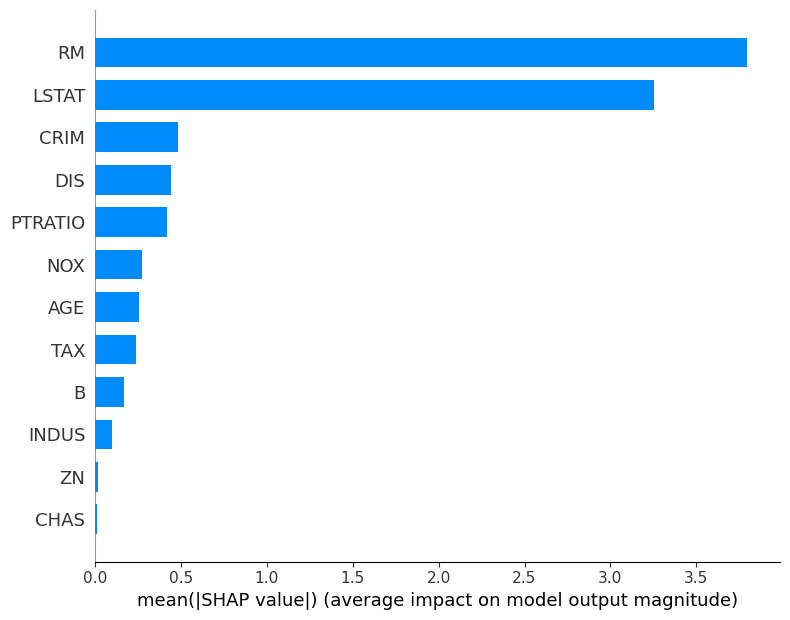

In [181]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [182]:
print("Random states:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", str(model[i]).split("=")[-1])

Random states:

CRIM = 1608637542)
ZN = 1273642419)
INDUS = 1935803228)
CHAS = 787846414)
NOX = 996406378)
RM = 1201263687)
AGE = 423734972)
DIS = 415968276)
TAX = 670094950)
PTRATIO = 1914837113)
B = 669991378)
LSTAT = 429389014)


## Partial dependences

## One-way Partial Dependences Plot show the dependence between the target output and initial input of the feature.

In [179]:
X100 = shap.utils.sample(X_train, 100) 

## On this plot we can see that LSTAT (% lower status of the population) is crucially affecting the prices of the houses in target regions.

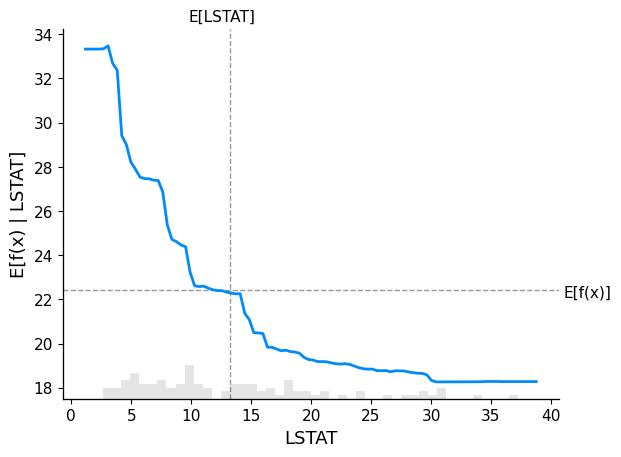

In [180]:
shap.partial_dependence_plot(
    "LSTAT",
    model.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

## In addition, RM(average number of rooms per dwelling) is also one of the most important feature that affects the catual price (because of the square meters for sale) and dependance is shown by that plot:

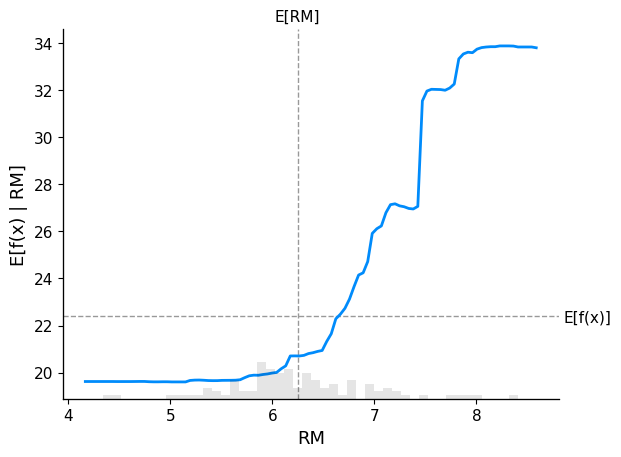

In [181]:
shap.partial_dependence_plot(
    "RM",
    model.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

## We see that most of the dots are set in the formed figure so we have linear relationship based on this feature.

## Outliers with exceptionally high 'RM' values exhibit even greater positive impacts, suggesting these properties might be luxurious or premium residences, influencing prices significantly beyond the average.

PermutationExplainer explainer: 103it [00:20,  2.66it/s]                         


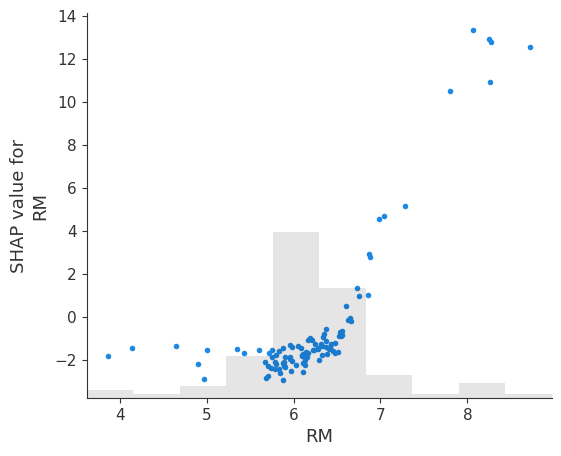

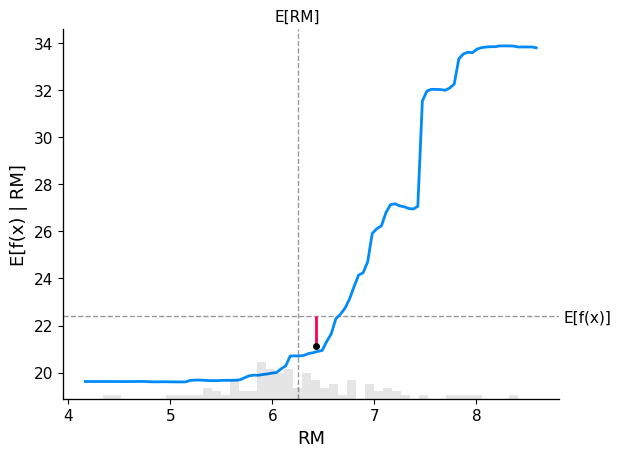

In [182]:
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X_test)
shap.plots.scatter(shap_values[:, "RM"])

sample_ind = 20
shap.partial_dependence_plot(
    "RM",
    model.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

### The SHAP values indicate that the number of rooms ('RM') has a consistently positive effect on house price predictions. However, for homes with high percentages of lower status population ('LSTAT'), the positive effect of 'RM' diminishes, possibly indicating an interaction effect between these two features. 

FEATURE_DEPENDENCE::independent does not support interactions!


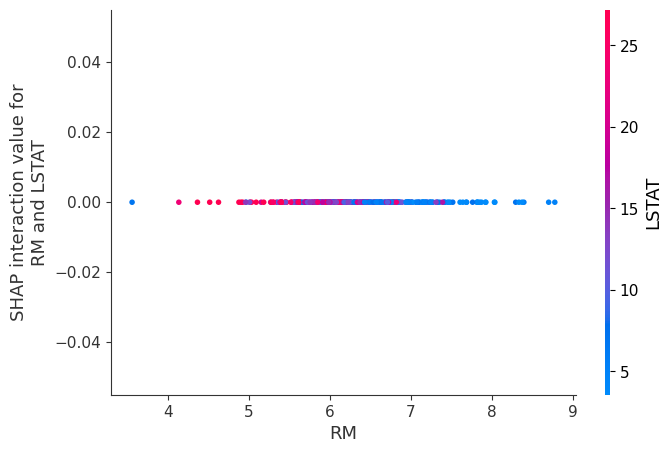

In [184]:
feature_1 = 'RM' 
feature_2 = 'LSTAT'  
explainer = shap.Explainer(model, X_train)
shap_values = explainer.shap_interaction_values(X_train[[feature_1, feature_2]])
shap.dependence_plot((feature_1, feature_2), shap_values, X_train[[feature_1, feature_2]])

plot illustrates how the predicted outcome ('MEDV') varies concerning changes in both selected features simultaneously.

It shows the interaction effect between the two features on the model predictions, offering insights into how their joint variations impact the model's output.

    feature  importance
12    LSTAT    0.514174
5        RM    0.400461
7       DIS    0.062188
0      CRIM    0.029562
4       NOX    0.017544
10  PTRATIO    0.015387
11        B    0.011861
9       TAX    0.005587
6       AGE    0.001019
1        ZN    0.000426
3      CHAS    0.000404
2     INDUS   -0.000016
8       RAD   -0.002475


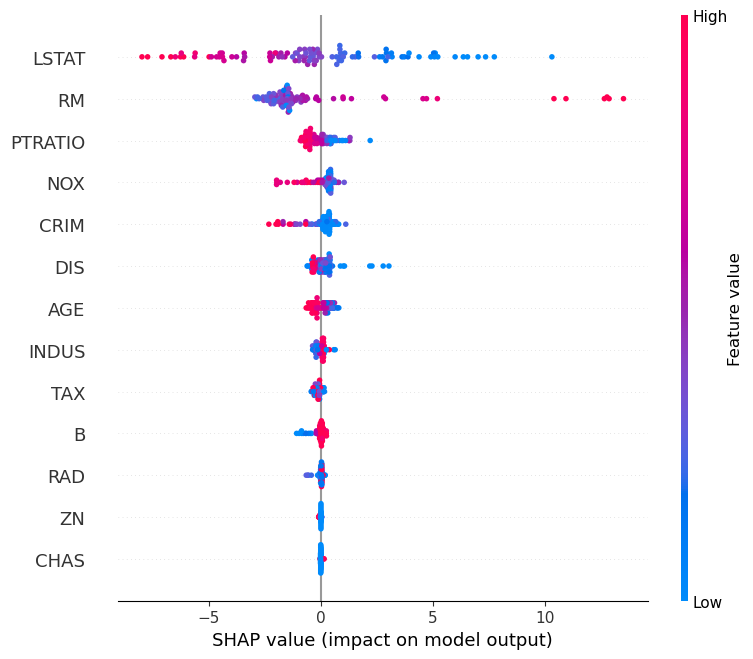

In [186]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test, Y_test, n_repeats=10, random_state=42)

feature_importance = pd.DataFrame(
    {'feature': X_test.columns, 'importance': perm_importance.importances_mean}
)
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
print(feature_importance)
explainer = shap.Explainer(model, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### Features with Positive Importance:
LSTAT (0.514): This feature has the highest positive importance score, suggesting that the model's performance significantly decreases when the values of 'LSTAT' (percentage of lower status of the population) are randomly shuffled. It indicates that 'LSTAT' is crucial for the model's predictions.

RM (0.400): 'RM' (average number of rooms per dwelling) is the second most important feature according to the permutation importance measure. Its high positive score indicates its significant impact on the model's performance.

DIS (0.062): 'DIS' (weighted distances to five Boston employment centers) has a lower importance score compared to 'LSTAT' and 'RM' but still contributes positively to the model's performance.

CRIM, NOX, PTRATIO, B, TAX, AGE, ZN, CHAS: These features also contribute positively to the model's performance, although their importance scores are relatively smaller compared to 'LSTAT' and 'RM'.

### Features with Negative or Close to Zero Importance:
RAD (-0.002): 'RAD' (index of accessibility to radial highways) has a slightly negative importance score, indicating that shuffling this feature's values has a negligible impact on the model's performance.

INDUS (-0.000): 'INDUS' (proportion of non-retail business acres per town) has an importance score very close to zero, suggesting minimal impact on model performance upon shuffling.



## Result of permutation analysis:

'LSTAT' and 'RM' are the most influential features according to the permutation importance measure, indicating that these variables are critical in predicting the target ('MEDV' - median value of owner-occupied homes).
'RAD' and 'INDUS' have the least impact according to this measure, suggesting that the model is less sensitive to changes in these features.

## The positive and negative relationships of the predictors with the target variable

In [188]:
shap_values = explainer.shap_values(X_train)

PermutationExplainer explainer: 405it [00:14,  8.75it/s]                         


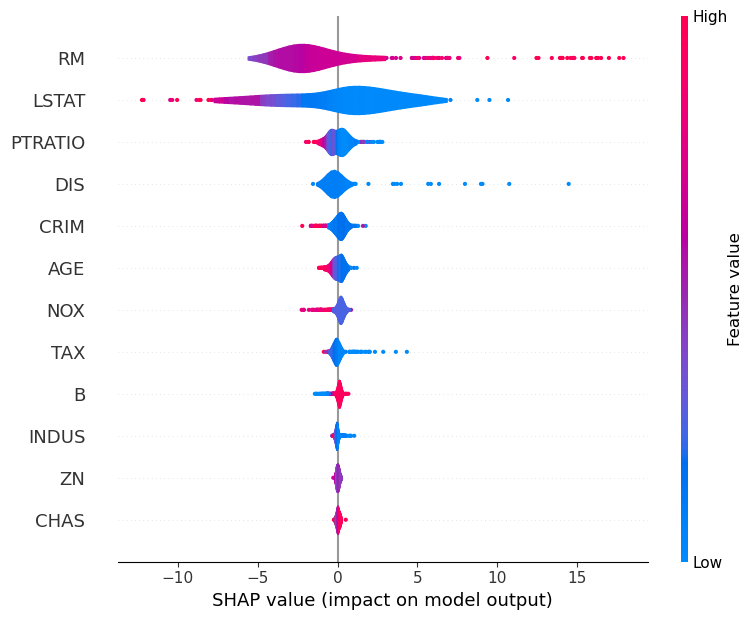

In [189]:
shap.summary_plot(shap_values, X_train, plot_type='violin')

### How LSTAT (lower status) correlates with CRIM:

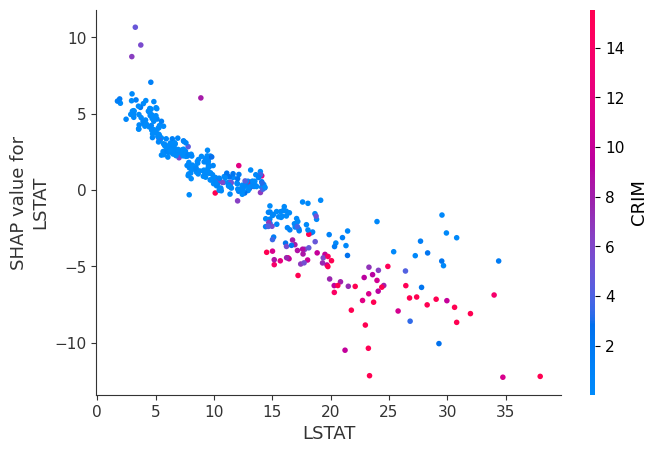

In [190]:
shap.dependence_plot("LSTAT", shap_values, X_train, feature_names=X_train.columns)

This summary plot is made of all the dots in the train data. It demonstrates the following information:

- *__Correlation__: A high level of people with lower status has an impact on increasinf of criminalirty leven in the region. The “high” comes from the red color. Similarly*

In [226]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_test)

PermutationExplainer explainer: 103it [00:16,  2.59it/s]                         


### This visualization helps in explaining the step-by-step contributions of each feature towards the model's decision for a particular data point.


### LSTAT: A SHAP value of +2.70 indicates that higher values of 'LSTAT' (percentage of lower status population) lead to an increase in the predicted median value of owner-occupied homes (MEDV). In simpler terms, areas with a higher percentage of lower status population tend to correlate with higher predicted home values.

### RM: A SHAP value of -1.74 suggests that higher values of 'RM' (average number of rooms per dwelling) correspond to a decrease in the predicted median value of owner-occupied homes (MEDV). 

### Other features had relatively smaller contributions

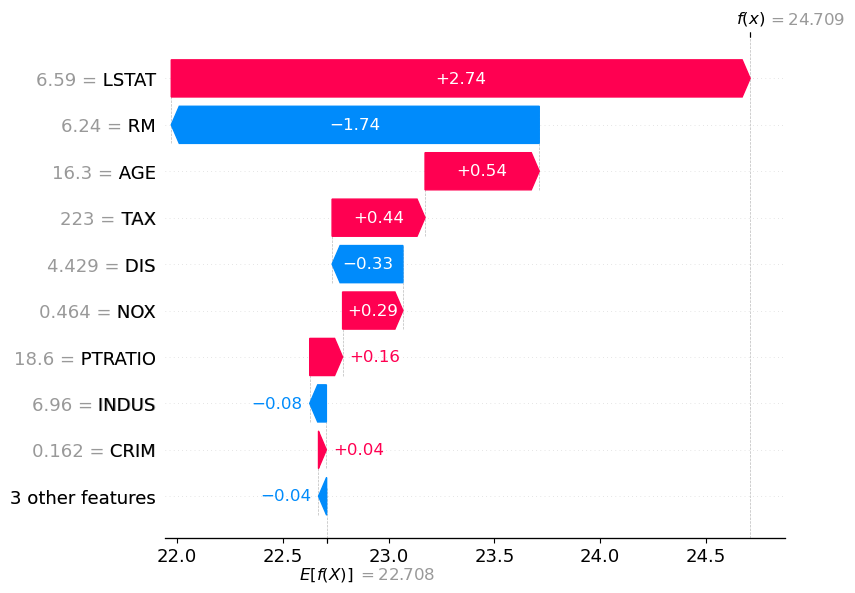

In [227]:
shap.plots.waterfall(shap_values[sample_ind])

## Heatmap visualization of SHAP values across all features for multiple samples or instances. 

### This visualization offers a comprehensive view of how different features contribute to the model's predictions across various data points.

### The color intensity and shades represent the magnitude and direction of SHAP values. Warmer colors (e.g., red) indicate stronger positive contributions, while cooler colors (e.g., blue) indicate stronger negative contributions.

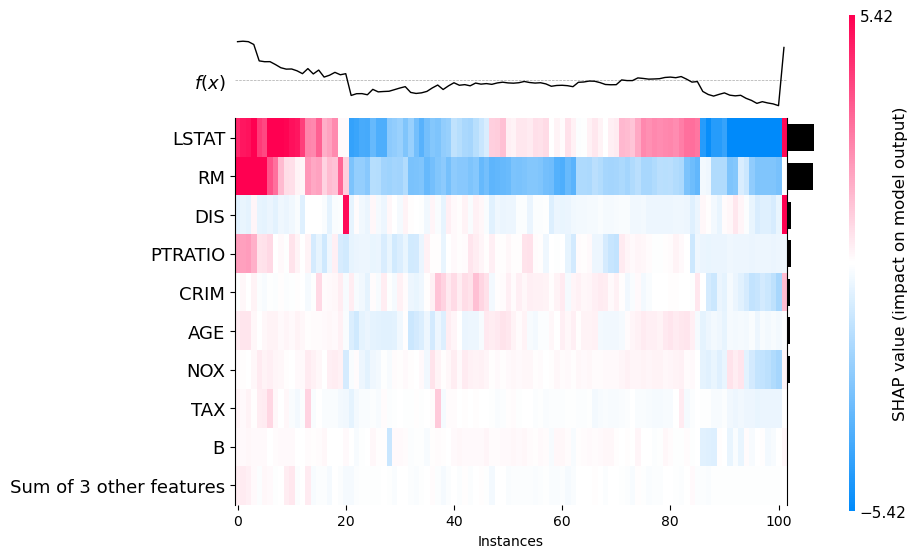

In [194]:
shap.plots.heatmap(shap_values)

### X-axis ("LSTAT") vs. Y-axis ("RM"): Each point on the scatter plot represents an instance from my dataset.

### The color of each point represents the SHAP value magnitude or direction for the "RM" feature. Differences in color intensity or hue indicate varying impacts of "RM" on model predictions across different instances.

### This plot helps in visualizing how the SHAP values of "LSTAT" and "RM" interact or relate to each other concerning their impacts on model predictions.



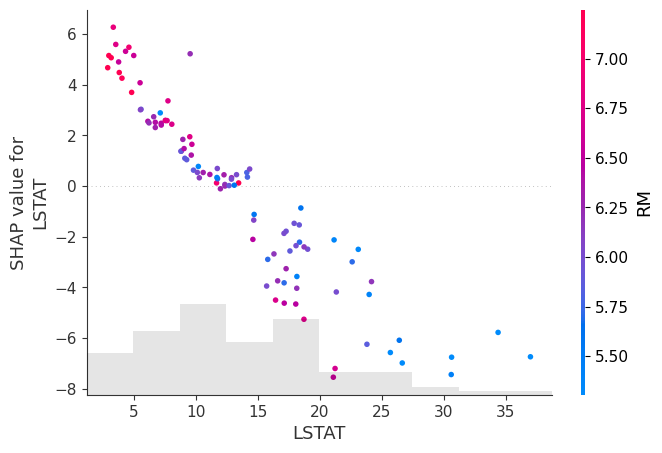

In [231]:
shap.plots.scatter(shap_values[:, "LSTAT"], color=shap_values[:, "RM"])

--------------------------------------------------------------------------------------------------------------------------------

## SHAP Interaction Values

To provide a  matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. 

In [235]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_train)

### SHAP Interaction Value Summary Plot — Global Interpretability

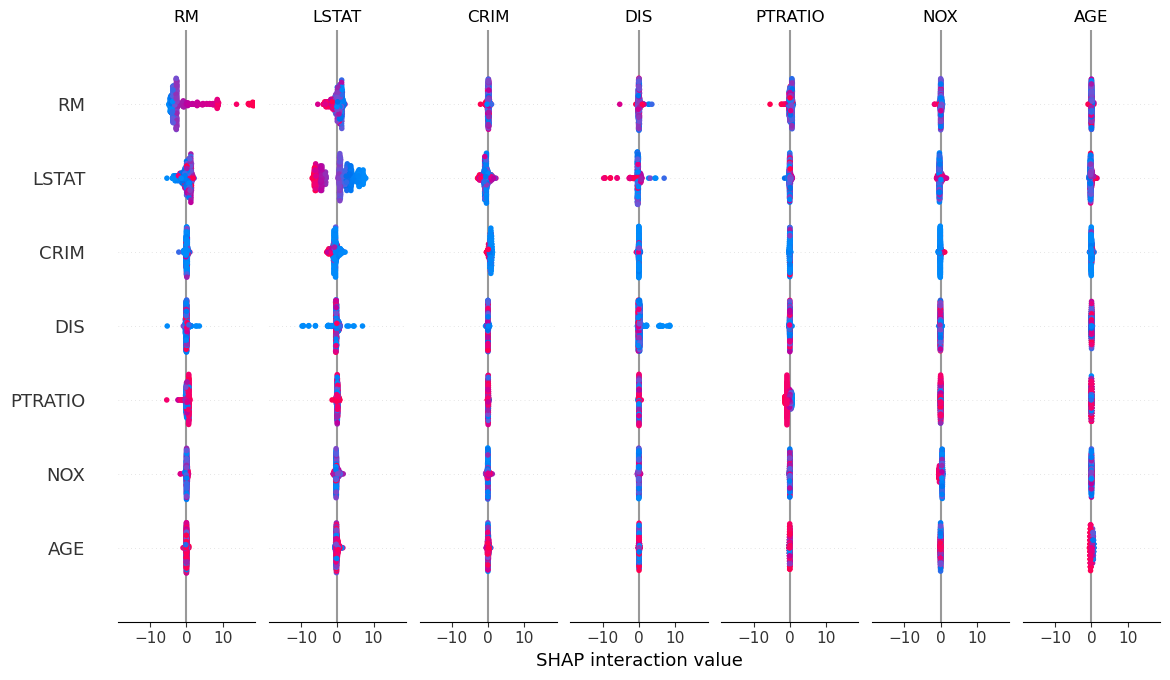

In [237]:
shap.summary_plot(shap_interaction_values, X_train)

This matrix showed some hidden relationships

--------------------------------------------------------------------------------------------------------------------------------

### SHAP Interaction Value Dependence Plots — Global Interpretability

separate observation of the main effects and the interaction effects.

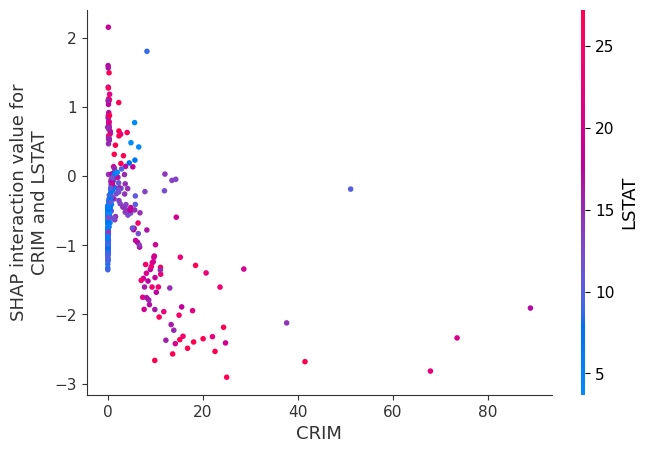

In [239]:
shap.dependence_plot(
    ("CRIM", "LSTAT"),
    shap_interaction_values, X_train,
    display_features=X_train
)

### SHAP Dependence Plot — Global Interpretability

The partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model. __It tells whether the relationship between the target and a feature is linear, monotonic or more complex__. The function automatically includes another variable that your chosen variable interacts most with.

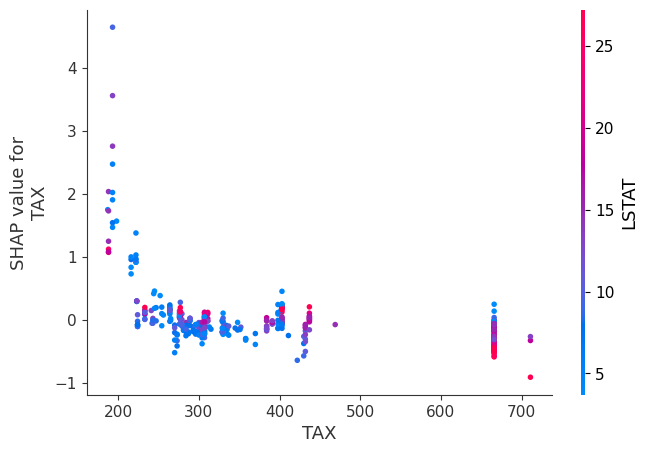

In [205]:
shap.dependence_plot("TAX", shap_values, X_train)

--------------------------------------------------------------------------------------------------------------------------------

### Individual SHAP Value Plot — Local Interpretability

In [125]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

Features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

The length and color of the bars in the force plot show the magnitude and direction of each feature's impact on the prediction.

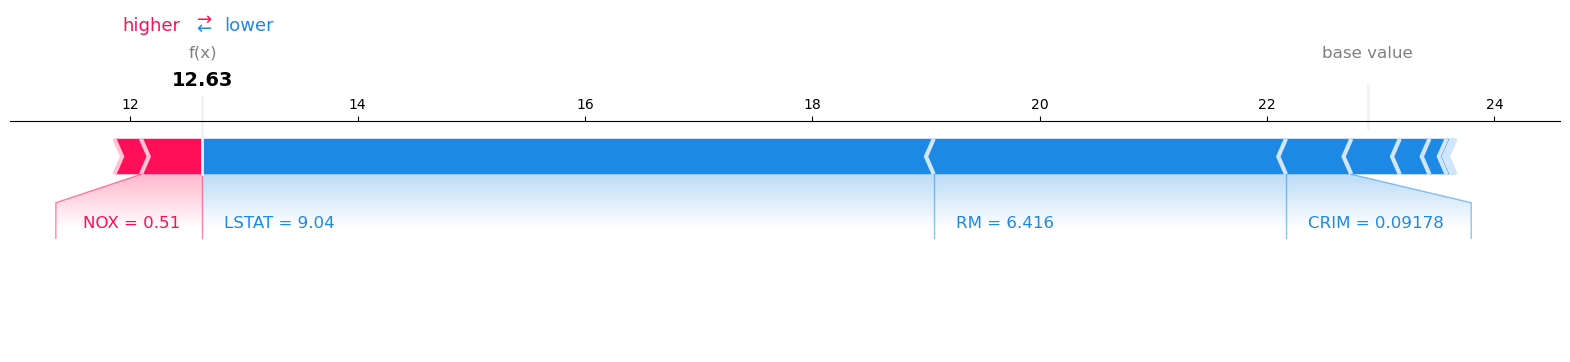

In [126]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], matplotlib=True)

on this plot:

low level of nitric oxides concentration (0.51) pushes the result to the top, when hight level of LSTAT(low status),big number of RM ( average number of rooms per dwelling) and CRIMinal level push the result lower

another 4 examples:

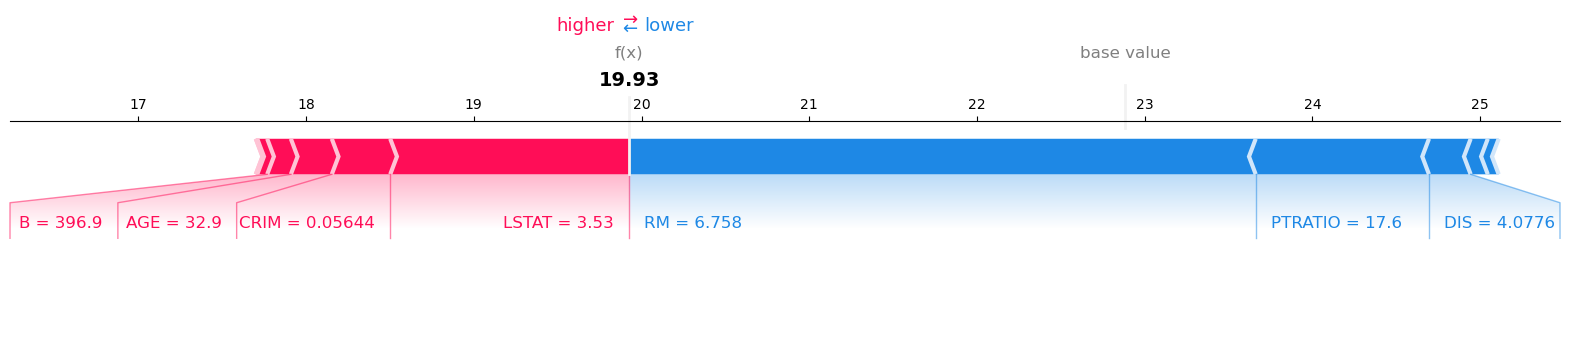

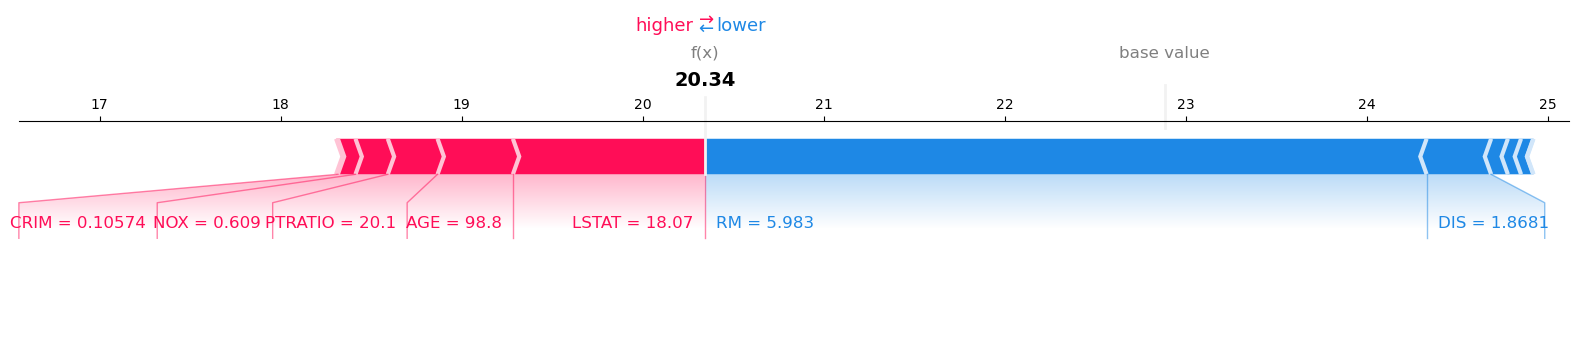

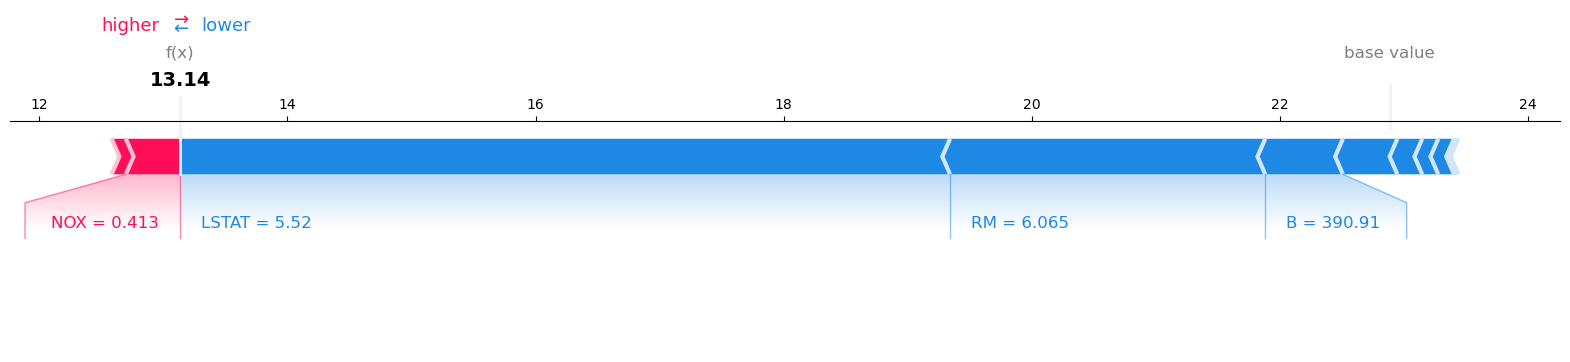

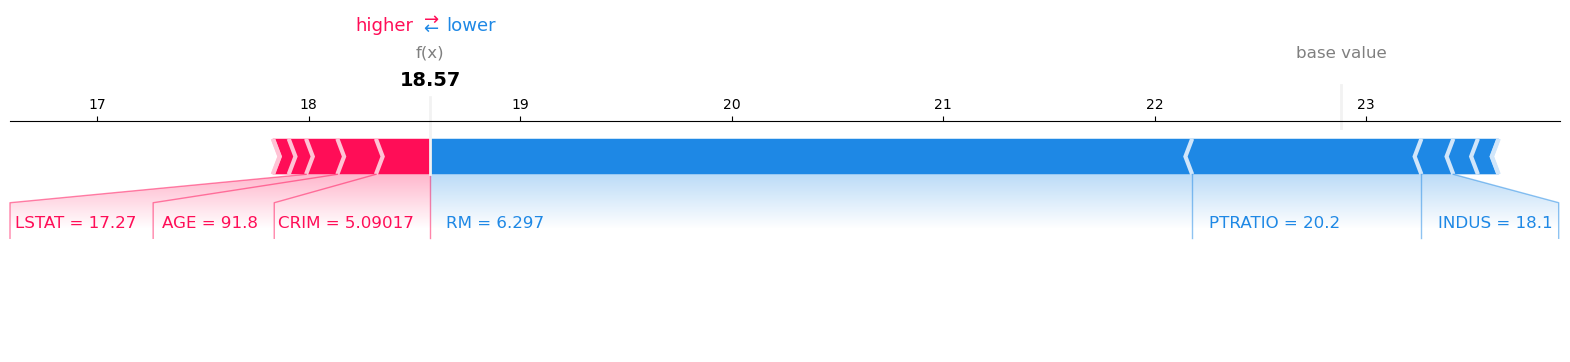

In [127]:
num_plots = 5

for i in range(1, num_plots):
    shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i], matplotlib=True)

- CRIM (Per Capita Crime Rate): Typically, lower crime rates might positively influence housing prices in a neighborhood. Higher crime rates could have a negative impact.

- ZN (Proportion of Residential Land Zoned): Higher proportions of residential land could positively influence prices if the area is deemed desirable for housing.

- INDUS (Proportion of Non-Retail Business Acres): Higher industrial zones might have a slightly negative influence on housing prices due to potential noise or commercial activity.

- CHAS (Charles River Dummy Variable): Being along the Charles River might positively impact housing prices due to proximity to water and associated amenities.

- NOX (Nitric Oxides Concentration): Higher levels of NOX might negatively impact housing prices due to potential health and environmental concerns.

- RM (Average Number of Rooms per Dwelling): More rooms generally mean larger houses, which could positively influence prices.

- AGE (Proportion of Owner-Occupied Units Built before 1940): Older houses might have charm but could require more maintenance, potentially impacting prices negatively.

- DIS (Weighted Distance to Employment Centers): Closer proximity to employment centers might positively affect housing prices due to convenience.

- RAD (Accessibility to Radial Highways): Better highway accessibility might positively impact housing prices by improving commuting convenience.

- TAX (Property Tax Rate): Higher property tax rates might lower housing affordability and could have a negative impact on prices.

- PTRATIO (Pupil-Teacher Ratio): Lower ratios might indicate better-funded schools and might positively impact housing prices.

- B (Proportion of Black Population): Unfortunately, historically, higher proportions of Black populations have been associated with lower housing prices due to discriminatory practices.

- LSTAT (Percentage of Lower Status Population): Higher percentages might negatively impact housing prices due to socio-economic factors.

MEDV (Median Value of Owner-Occupied Homes): value to predict. It represents the median value of owner-occupied homes and is influenced by all the above factors in varying degrees.

In [82]:
shap.force_plot(explainer.expected_value, shap_values[:6], X_test.iloc[:6])


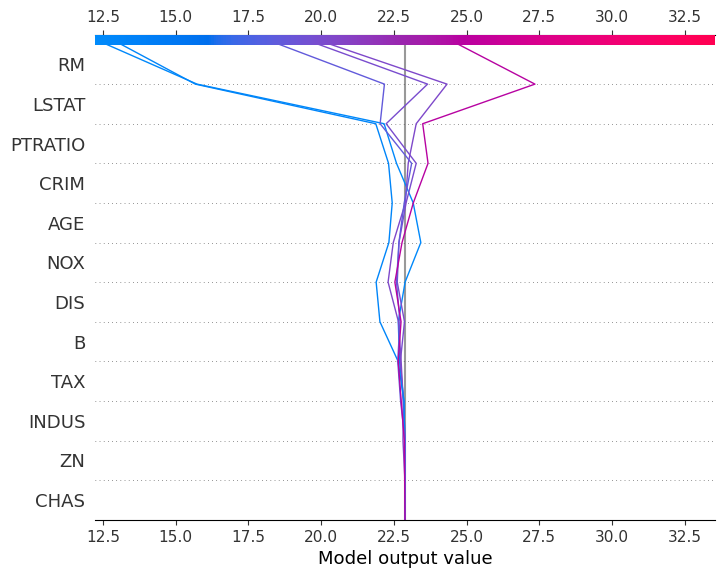

In [89]:
shap.decision_plot(explainer.expected_value, shap_values[:6], X_test.columns)


Feature Importance: Features such as RM (Average Number of Rooms) and LSTAT (Percentage of Lower Status Population) consistently exhibit substantial influence on model predictions across multiple samples.

Directionality: While RM positively impacts predictions (lines are heading to the right ), LSTAT  shows mixed influences (both positive and negative) across different samples.

There is how the model is desiding on every entry in the TEST dataset:

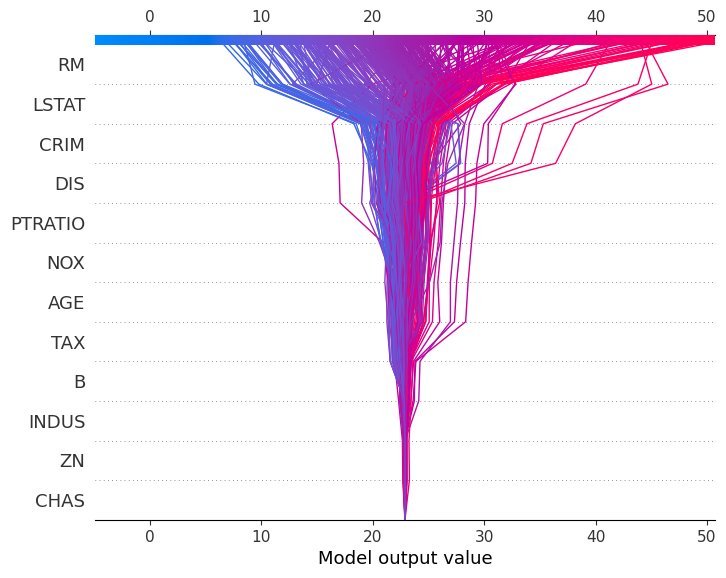

In [225]:
shap.decision_plot(explainer.expected_value, shap_values, X_test.columns)


Some data on the train and test sets:

mean value might be the the treshold to push the result to different sides (after testing the theory on some examples and this values coinside)

In [216]:
X_train.mean()

CRIM         3.609125
ZN          11.569307
INDUS       10.985050
CHAS         0.071782
NOX          0.556484
RM           6.315891
AGE         68.556436
DIS          3.808195
TAX        404.032178
PTRATIO     18.318317
B          356.278342
LSTAT       12.457351
dtype: float64

In [95]:
print("",Y_train.mean(), "\n", Y_test.mean() )

 22.796534653465343 
 21.488235294117644


In [96]:
X_train.iloc[:6]

CRIM    ZN  INDUS  CHAS     NOX     RM   AGE     DIS    TAX  PTRATIO  \
477  15.02340   0.0  18.10     0  0.6140  5.304  97.3  2.1007  666.0     20.2   
15    0.62739   0.0   8.14     0  0.5380  5.834  56.5  4.4986  307.0     21.0   
332   0.03466  35.0   6.06     0  0.4379  6.031  23.3  6.6407  304.0     16.9   
423   7.05042   0.0  18.10     0  0.6140  6.103  85.1  2.0218  666.0     20.2   
19    0.72580   0.0   8.14     0  0.5380  5.727  69.5  3.7965  307.0     21.0   
325   0.19186   0.0   7.38     0  0.4930  6.431  14.7  5.4159  287.0     19.6   

          B  LSTAT  
477  349.48  24.91  
15   395.62   8.47  
332  362.25   7.83  
423    2.52  23.29  
19   390.95  11.28  
325  393.68   5.08

--------------------------------------------------------------------------------------------------------------------------------

### Entire dataset SHAP Value interactive Plot — Local Interpretability

## please, adjust to LSTAT-sample order by output value

In [130]:
shap.force_plot(explainer.expected_value, shap_values, X_train)

--------------------------------------------------------------------------------------------------------------------------------

*For example, with this  plot, we can find out what is the threshold for the LSTAT that pushes the model predictions higher.*

here: LSTAT-by similarity

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_train)

*same operation for the second from most important values in the dataset*

here: RM - by similarity

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_train)

In [175]:
import dowhy
from dowhy import CausalModel

## Causal Estimate

Type: Nonparametric Average Treatment Effect

The expression shows the estimation of the change in 'MEDV' (median home value) concerning 'RM' (average number of rooms), while controlling for other variables ('NOX', 'CHAS', 'ZN', 'B', 'CRIM', 'PTRATIO', 'RAD', 'AGE', 'LSTAT', 'TAX', 'DIS', 'INDUS').

Estimand assumption 1 (Unconfoundedness) ensures that the relationship observed between 'RM' and 'MEDV' is not biased by hidden variables.


In [178]:
train_data = pd.concat([X_train, Y_train], axis=1)

causal_model = CausalModel(
    data=train_data,
    treatment='RM', 
    outcome='MEDV', 
    common_causes=X.columns.drop('RM').tolist()
)

identified_estimand = causal_model.identify_effect()
estimate = causal_model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                  
─────(E[MEDV|NOX,CHAS,ZN,B,CRIM,PTRATIO,RAD,AGE,LSTAT,TAX,DIS,INDUS])
d[RM]                                                                
Estimand assumption 1, Unconfoundedness: If U→{RM} and U→MEDV then P(MEDV|RM,NOX,CHAS,ZN,B,CRIM,PTRATIO,RAD,AGE,LSTAT,TAX,DIS,INDUS,U) = P(MEDV|RM,NOX,CHAS,ZN,B,CRIM,PTRATIO,RAD,AGE,LSTAT,TAX,DIS,INDUS)

## Realized estimand
b: MEDV~RM+NOX+CHAS+ZN+B+CRIM+PTRATIO+RAD+AGE+LSTAT+TAX+DIS+INDUS
Target units: ate

## Estimate
Mean value: 3.7087090122190394



The estimated Average Treatment Effect (ATE) is approximately 3.71. This suggests that, on average, for each additional room in a dwelling ('RM'), the median home value ('MEDV') tends to increase by around $3.71 thousand, holding other factors constant.

# Text analysis

## Twitter classification

Dataset contains information about tweets: 


columns:
- tweet_id
- airline_sentiment
- airline_sentiment_confidence, negativereason, negativereason_confidence, airline, airline_sentiment_gold, name, negativereason_gold, retweet_count (metadata)
- text
- tweet_coord,tweet_created,tweet_location,user_timezone (metadata)


## classification into 3 clasters

Accuracy: 0.7967896174863388


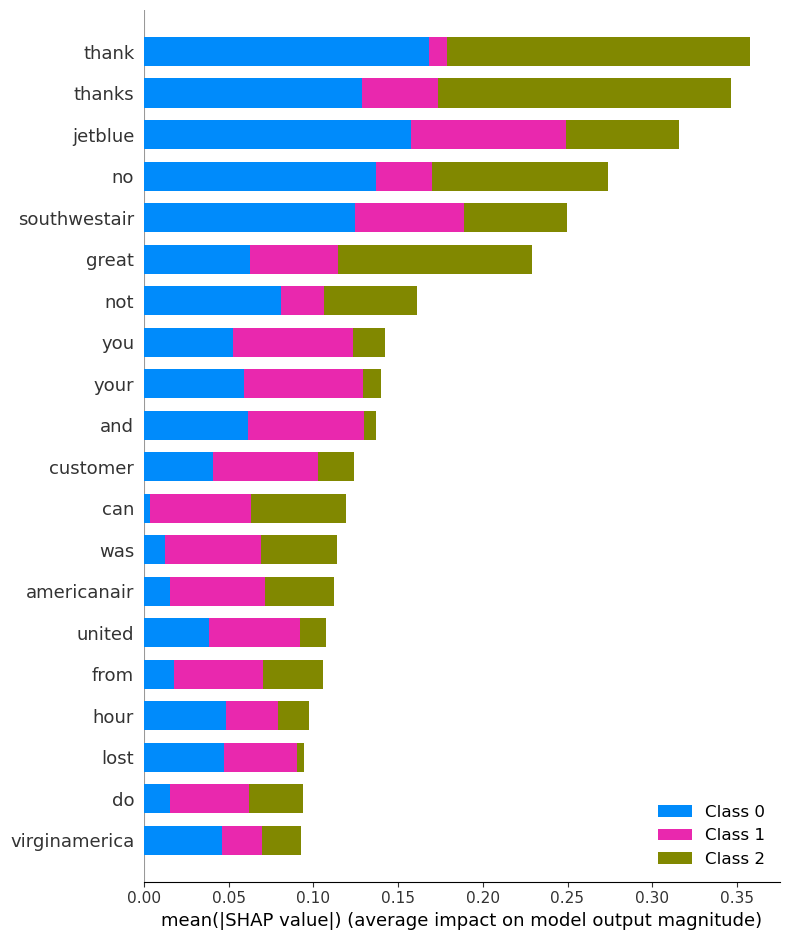

In [149]:
data = pd.read_csv("tweet/Tweets.csv")
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return text
data['text'] = data['text'].apply(clean_text)

label_encoder = LabelEncoder()
data['airline_sentiment_encoded'] = label_encoder.fit_transform(data['airline_sentiment'])
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(data['text'])

X_train, X_test, y_train, y_test = train_test_split(X, data['airline_sentiment_encoded'], test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test[:100])
shap.summary_plot(shap_values, X_test[:100], feature_names=tfidf_vectorizer.get_feature_names_out())


## classification on binary results ( with dropping neutral results)

Accuracy: 0.913382416630576
[[{'label': 'negative', 'score': 0.5761056059888163}, {'label': 'positive', 'score': 0.42389439401118373}], [{'label': 'negative', 'score': 0.6874115105323809}, {'label': 'positive', 'score': 0.3125884894676191}], [{'label': 'negative', 'score': 0.6427822730018188}, {'label': 'positive', 'score': 0.3572177269981812}], [{'label': 'negative', 'score': 0.920897074053826}, {'label': 'positive', 'score': 0.07910292594617398}], [{'label': 'negative', 'score': 0.5371003063883765}, {'label': 'positive', 'score': 0.46289969361162353}], [{'label': 'negative', 'score': 0.5974902129897366}, {'label': 'positive', 'score': 0.40250978701026346}], [{'label': 'negative', 'score': 0.18297352431557268}, {'label': 'positive', 'score': 0.8170264756844273}], [{'label': 'negative', 'score': 0.19837050942720547}, {'label': 'positive', 'score': 0.8016294905727945}], [{'label': 'negative', 'score': 0.7979201112335239}, {'label': 'positive', 'score': 0.20207988876647603}], [{'label': 

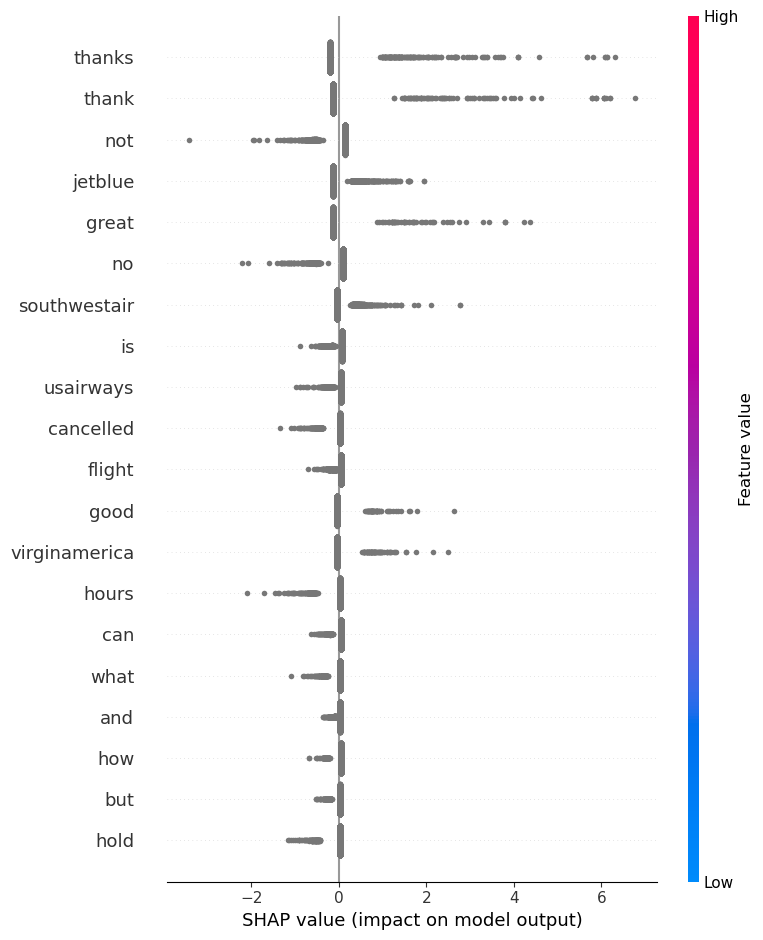

In [150]:
data = pd.read_csv("tweet/Tweets.csv")
data = data[['text', 'airline_sentiment']]
data = data[data.airline_sentiment != 'neutral']

data['text'] = data['text'].apply(clean_text)

label_encoder = LabelEncoder()
data['airline_sentiment_encoded'] = label_encoder.fit_transform(data['airline_sentiment'])
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(data['text'])

X_train, X_test, y_train, y_test = train_test_split(X, data['airline_sentiment_encoded'], test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

input_text_list = data['text']
results = []
for text in input_text_list:
    cleaned_text = clean_text(text)
    text_vector = tfidf_vectorizer.transform([cleaned_text])
    prediction = model.predict(text_vector)
    probabilities = model.predict_proba(text_vector)
    sentiment_label = label_encoder.inverse_transform(prediction)[0]
    scores = [{'label': label, 'score': score} for label, score in zip(label_encoder.classes_, probabilities[0])]
    results.append(scores)

print(results)


explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=tfidf_vectorizer.get_feature_names_out())

## Just to show, what else can SHAP do with text analysis:

some results from classification on standart IBM database using classifier:

In [ ]:
shap.plots.text(shap_values[3])

In [ ]:
shap.plots.text(shap_values[4])

## GPT - another example of text analysis

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
model = AutoModelForCausalLM.from_pretrained("gpt2")

In [ ]:
model.config.is_decoder = True
model.config.task_specific_params["text-generation"] = {
    "do_sample": True,
    "max_length": 50,
    "temperature": 0.7,
    "top_k": 50,
    "no_repeat_ngram_size": 2,
}

In [ ]:
teacher_forcing_model = shap.models.TeacherForcing(model, tokenizer)
masker = shap.maskers.Text(tokenizer, mask_token="...", collapse_mask_token=True)

In [ ]:
x = [
    "I know many programmers.",
    "I know many lawers",
    "I know many doctors",
    "I know many artists",
    "I know many window cleaners",
    "I know many waiters",
    "I know many engineers",
    "I know many singers",
]

In [ ]:
y = [
    "They love code",
    "They love code",
    "They love code",    
    "They love code",
    "They love code",    
    "They love code",
    "They love code",
    "They love code",
]

Proccess of looking for associations:

In [ ]:
teacher_forcing_model = shap.models.TeacherForcing(model, tokenizer)
masker = shap.maskers.Text(tokenizer, mask_token="...", collapse_mask_token=True)
explainer = shap.Explainer(teacher_forcing_model, masker)
shap_values = explainer(x, y)
shap.plots.text(shap_values)


Analysis above works similarly to regular one in previous tasks


Also, here is the plot of SHAP values and their impact on the model 

(Of course, programmers love code at most)

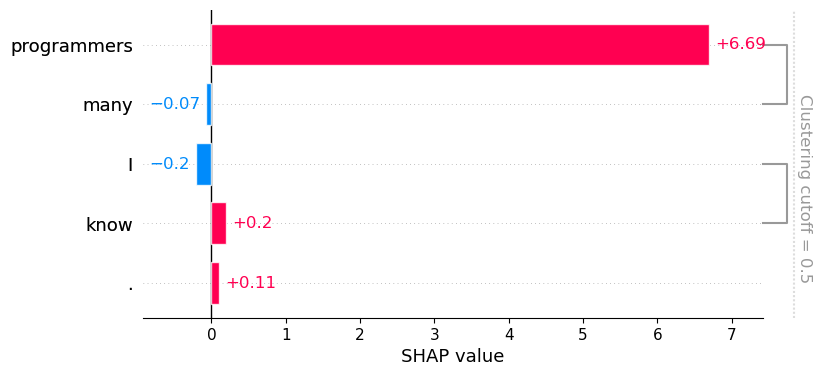

In [ ]:
shap.plots.bar(shap_values[0, :, "code"])

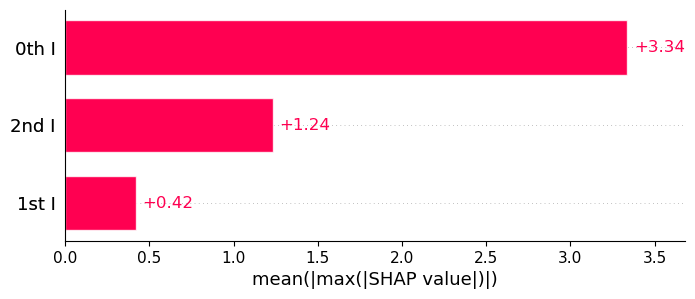

In [ ]:
shap.plots.bar(shap_values.abs.max(0))

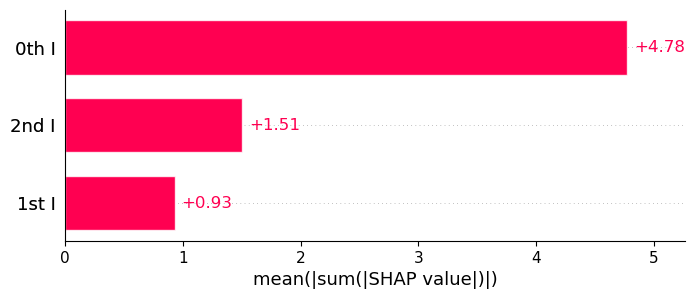

In [ ]:
shap.plots.bar(shap_values.abs.sum(0))